# Key insight into Tunisia using data visualization 
This Kaggle project delves into the fascinating world of Tunisian property prices, using data analysis and visualization to uncover hidden trends and insights, using a free data set scraped from Tayara.tn

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib


In [296]:
df = pd.read_csv('Property Prices in Tunisia.csv')
df.head()

,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,100000.0,Ariana,Raoued,5.000000
1,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,316000.0,Ariana,Autres villes,5.499687
2,Appartements,2.0,1.0,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
3,Locations de vacances,1.0,1.0,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
4,Appartements,2.0,2.0,113.0,À Vendre,170000.0,Ariana,Ariana Ville,5.230449


In [297]:
# Nettoyage initial
df = df.drop(columns=['log_price'], errors='ignore')


In [298]:

# Assuming df is the loaded DataFrame from the CSV
# Print initial DataFrame info
print("Initial Size:", df.size)
print("Initial Shape:", df.shape)
print("\nInitial DataFrame Info:")
print(df.info())

# 1. Standardize category names
df['category'] = df['category'].replace({
    "Magasins, Commerces et Locaux industriels": "Locaux industriels",
    "Maisons et Villas": "Villas",
    "Locations de vacances": "Vacation Rentals",
    "Bureaux et Plateaux": "Offices",
    "Colocations": "Shared Housing"
})

# 2. Remove 'Terrains et Fermes' entries
df = df[df['category'] != 'Terrains et Fermes']

# 3. Replace -1 with NaN for numerical columns
numerical_cols = ['room_count', 'bathroom_count', 'size']
df[numerical_cols] = df[numerical_cols].replace(-1, np.nan)

# 4. Handle missing values
# Drop rows where price is missing (critical for analysis)
df.dropna(subset=['price'], inplace=True)

# Fill missing size with median size per category to preserve data
df['size'] = df.groupby('category')['size'].transform(lambda x: x.fillna(x.median()))

# Fill missing room_count and bathroom_count with 0 for non-residential properties
non_residential = ['Locaux industriels', 'Offices']
df.loc[df['category'].isin(non_residential), ['room_count', 'bathroom_count']] = df.loc[
    df['category'].isin(non_residential), ['room_count', 'bathroom_count']
].fillna(0)

# For residential properties, fill with median per category
residential = ['Appartements', 'Villas', 'Vacation Rentals', 'Shared Housing']
df.loc[df['category'].isin(residential), 'room_count'] = df.loc[
    df['category'].isin(residential), 'room_count'
].fillna(df.loc[df['category'].isin(residential), 'room_count'].median())
df.loc[df['category'].isin(residential), 'bathroom_count'] = df.loc[
    df['category'].isin(residential), 'bathroom_count'
].fillna(df.loc[df['category'].isin(residential), 'bathroom_count'].median())

# 5. Convert to appropriate data types
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')
df['room_count'] = pd.to_numeric(df['room_count'], errors='coerce').fillna(0).astype(int)
df['bathroom_count'] = pd.to_numeric(df['bathroom_count'], errors='coerce').fillna(0).astype(int)
df['type'] = df['type'].astype('category')
df['category'] = df['category'].astype('category')
df['city'] = df['city'].astype('category')
df['region'] = df['region'].astype('category')

# 6. Remove outliers (e.g., extreme prices or sizes)
# Define reasonable thresholds (adjust based on domain knowledge)
price_threshold = df['price'].quantile(0.99)  # Remove top 1% of prices
size_threshold = df['size'].quantile(0.99)    # Remove top 1% of sizes
df = df[(df['price'] <= price_threshold) & (df['size'] <= size_threshold)]

# 7. Validate data consistency
# Ensure price and size are positive
df = df[(df['price'] > 0) & (df['size'] > 0)]

# Recalculate log_price for consistency
df['log_price'] = np.log10(df['price'].clip(lower=1))  # Avoid log(0)

# Final cleaned DataFrame info
print("\nCleaned Shape:", df.shape)
print("\nCleaned DataFrame Info:")
print(df.info())
print("\nFirst 5 rows of cleaned DataFrame:")
print(df.head())

# Optional: Save cleaned data to a new CSV
df.to_csv('cleaned_property_prices_tunisia.csv', index=False)

Initial Size: 101984
Initial Shape: (12748, 8)

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748 entries, 0 to 12747
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        12748 non-null  object 
 1   room_count      12748 non-null  float64
 2   bathroom_count  12748 non-null  float64
 3   size            12748 non-null  float64
 4   type            12748 non-null  object 
 5   price           12748 non-null  float64
 6   city            12748 non-null  object 
 7   region          12748 non-null  object 
dtypes: float64(4), object(4)
memory usage: 796.9+ KB
None

Cleaned Shape: (9147, 9)

Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 9147 entries, 2 to 12747
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   category        9147 non-null   category
 1   room_count     

In [299]:
df = pd.read_csv('cleaned_property_prices_tunisia.csv')
df.head()

,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Appartements,2,1,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
1,Vacation Rentals,1,1,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
2,Appartements,2,2,113.0,À Vendre,170000.0,Ariana,Ariana Ville,5.230449
3,Vacation Rentals,1,1,70.0,À Louer,80.0,Ariana,Autres villes,1.903090
4,Appartements,2,1,100.0,À Louer,670.0,Ariana,Borj Louzir,2.826075


In [300]:
print("Size: ", df.size)
print("Shape:", df.shape)

# Corriger les catégories longues
df['category'] = df['category'].replace({
    "Magasins, Commerces et Locaux industriels": "Locaux industriels"
})

# Nettoyage des valeurs invalides
df['room_count'] = df['room_count'].replace(-1, np.nan)
df['bathroom_count'] = df['bathroom_count'].replace(-1, np.nan)
df['size'] = df['size'].replace(-1, np.nan)

# Pour Terrains et Fermes, pas de pièces -> 0
mask = df['category'] == 'Terrains et Fermes'
df.loc[mask, ['room_count', 'bathroom_count']] = 0
df.loc[mask & df['size'].isna(), 'size'] = df.loc[mask, 'size'].median()

# Supprimer les lignes avec prix nul ou négatif
df = df[df['price'] > 100]

# Supprimer les valeurs aberrantes sur le prix
q_low = df['price'].quantile(0.01)
q_high = df['price'].quantile(0.99)
df = df[(df['price'] >= q_low) & (df['price'] <= q_high)]

# Afficher les dimensions finales
print("Shape after cleaning:", df.shape)

Size:  82323
Shape: (9147, 9)
Shape after cleaning: (8508, 9)


# Most popular category for real estate in Tunisia

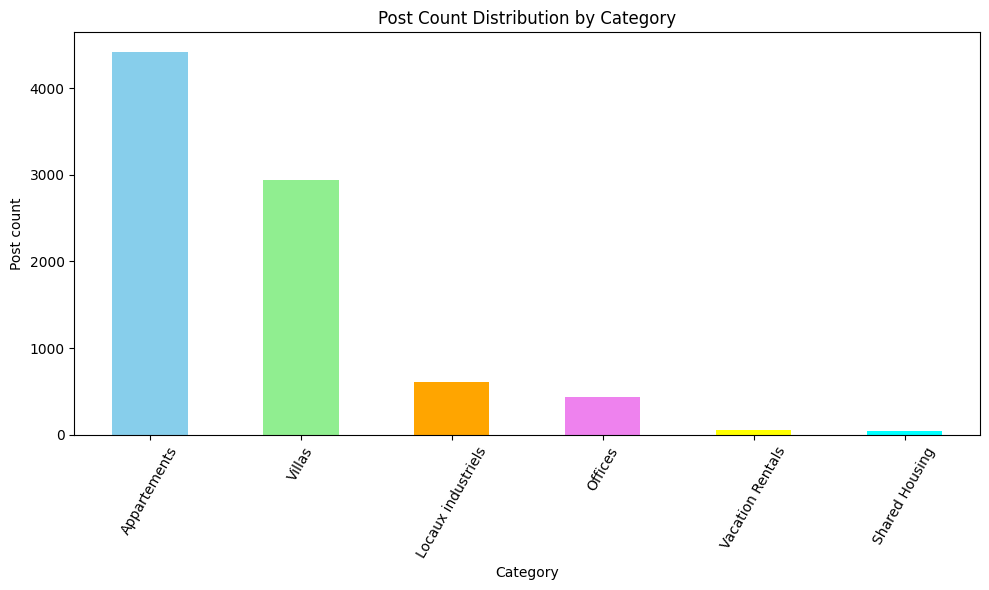

In [301]:
colors=["skyblue", "lightgreen", "orange","violet","yellow","cyan","red"]

plt.figure(figsize=(10, 6))
df.category.value_counts().plot(kind="bar", y="count", width=0.5, color=colors)
plt.xlabel("Category")
plt.ylabel("Post count")
plt.xticks(rotation=60)
plt.title("Post Count Distribution by Category")
plt.tight_layout()
plt.show()

# Cities with the most real estate sale posts

C:\Users\naim\AppData\Local\Temp\ipykernel_1912\3036989895.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


[Text(0, 0, 'Ariana'),
 Text(1, 0, 'Béja'),
 Text(2, 0, 'Ben arous'),
 Text(3, 0, 'Bizerte'),
 Text(4, 0, 'Gabès'),
 Text(5, 0, 'Gafsa'),
 Text(6, 0, 'Jendouba'),
 Text(7, 0, 'Kairouan'),
 Text(8, 0, 'Kasserine'),
 Text(9, 0, 'Kébili'),
 Text(10, 0, 'La manouba'),
 Text(11, 0, 'Le kef'),
 Text(12, 0, 'Mahdia'),
 Text(13, 0, 'Médenine'),
 Text(14, 0, 'Monastir'),
 Text(15, 0, 'Sidi bouzid'),
 Text(16, 0, 'Siliana'),
 Text(17, 0, 'Sousse'),
 Text(18, 0, 'Tataouine'),
 Text(19, 0, 'Tozeur'),
 Text(20, 0, 'Zaghouan'),
 Text(21, 0, 'Sfax'),
 Text(22, 0, 'Nabeul'),
 Text(23, 0, 'Tunis')]

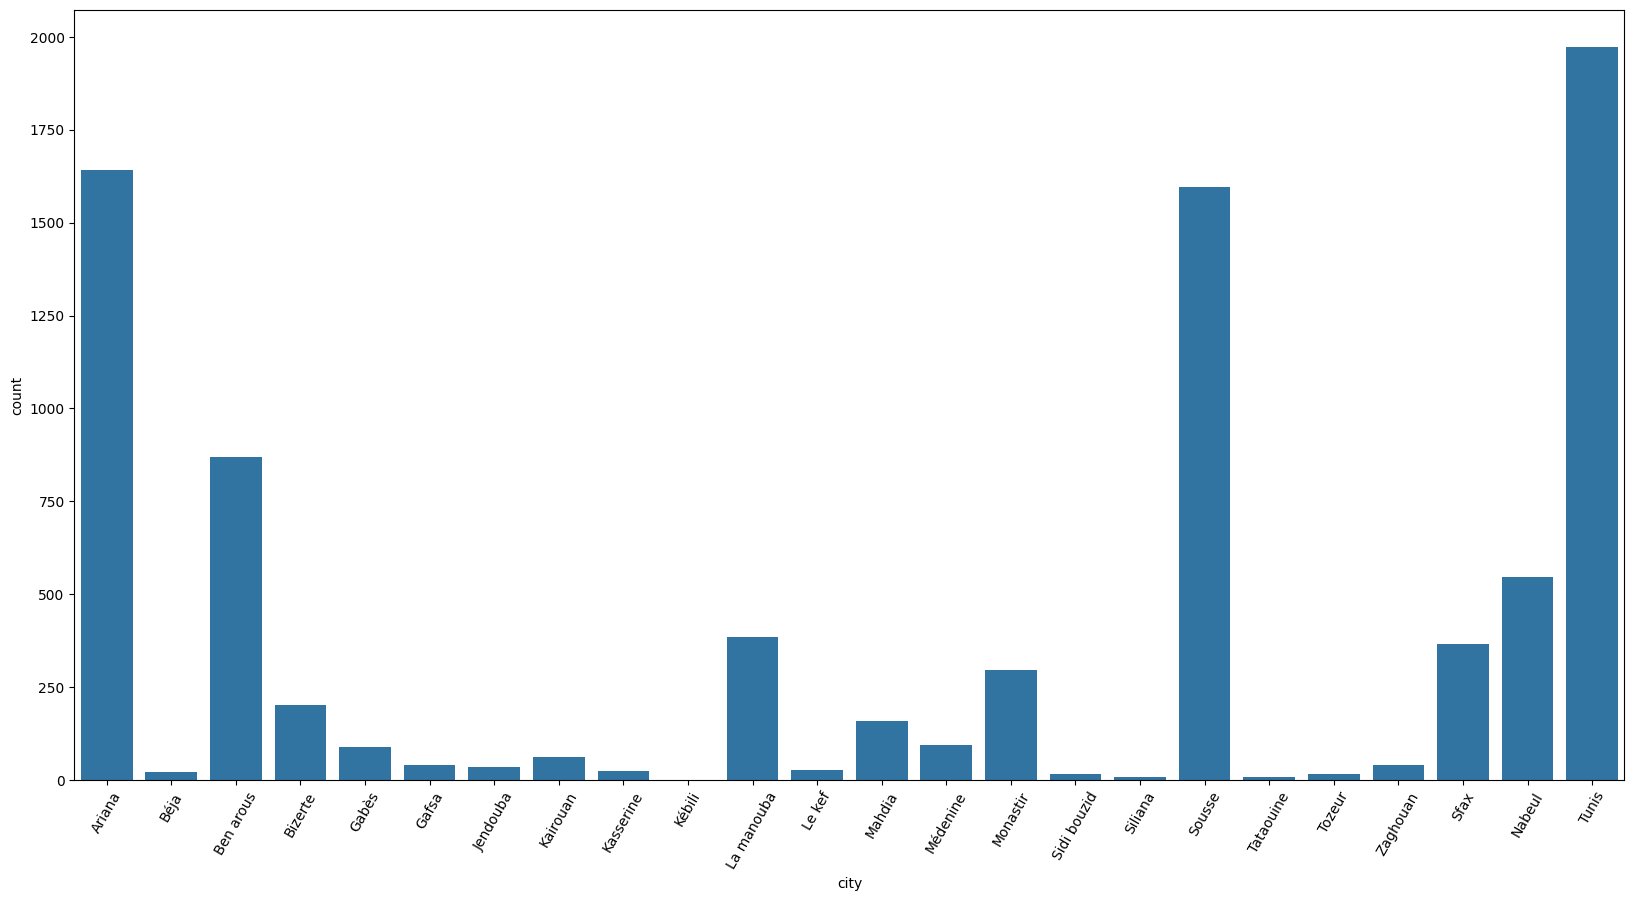

In [302]:
fig, ax = plt.subplots(figsize=(20, 10)) 

sns.countplot(df, x="city",ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

In [303]:
df['city'][df.type == "À Louer"].unique()

array(['Ariana', 'Béja', 'Ben arous', 'Bizerte', 'Gabès', 'Gafsa',
       'Jendouba', 'Kairouan', 'Kasserine', 'Kébili', 'La manouba',
       'Le kef', 'Mahdia', 'Médenine', 'Monastir', 'Sidi bouzid',
       'Siliana', 'Sousse', 'Tozeur', 'Zaghouan', 'Sfax', 'Nabeul',
       'Tunis'], dtype=object)

# Distribution of "For Sale" and "For Rent" posts per city

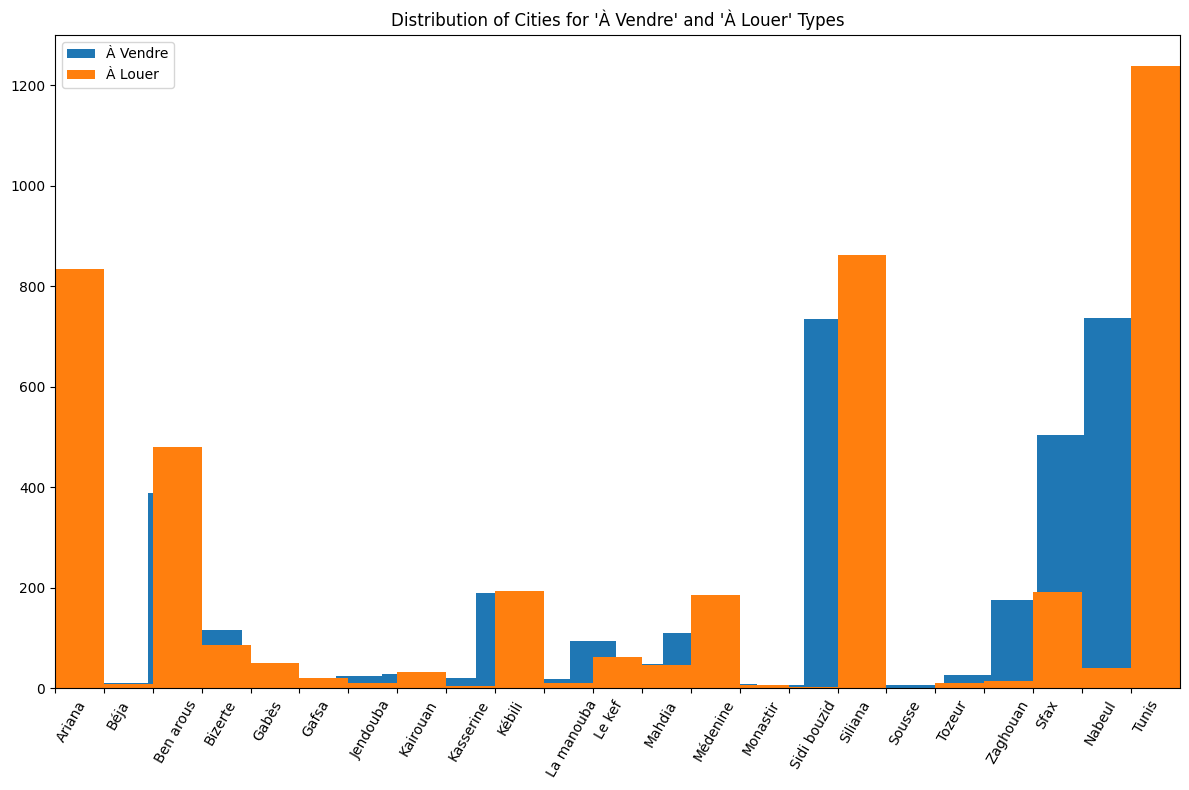

In [304]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Define city names as tick labels
city_names = df['city'][df.type == "À Louer"].unique()

# Create figure and axes
fig, axs = plt.subplots(figsize=(12, 8))

# Generate histograms with labels
axs.hist(df['city'][df.type == "À Vendre"], bins=23, label="À Vendre")
axs.hist(df['city'][df.type == "À Louer"], bins=23, label="À Louer")

# Set fixed tick locations and labels with rotation
axs.set_xlim(0,len(city_names))
xticks = range(len(city_names))
locator = FixedLocator(xticks)
axs.xaxis.set_major_locator(locator)
axs.set_xticklabels(city_names, rotation=90)

# Add legend and title
axs.legend()
axs.set_title("Distribution of Cities for 'À Vendre' and 'À Louer' Types")

# Rotate x-axis labels for better readability
plt.xticks(rotation=60,ha='left')

plt.tight_layout()
plt.show()


In [305]:
# Resizing dataset
df_app = df.filter(['category','price','size','type'], axis=1)
print(df_app)

                category     price   size      type
0           Appartements     380.0   80.0   À Louer
2           Appartements  170000.0  113.0  À Vendre
4           Appartements     670.0  100.0   À Louer
5     Locaux industriels     650.0   20.0   À Louer
6     Locaux industriels     450.0   40.0   À Louer
...                  ...       ...    ...       ...
9141        Appartements  110000.0   68.0  À Vendre
9142        Appartements  250000.0  140.0  À Vendre
9143        Appartements     600.0  100.0   À Louer
9145              Villas  240000.0  190.0  À Vendre
9146              Villas     500.0   70.0   À Louer

[8508 rows x 4 columns]


# Cities with most real estate posts, sorted

C:\Users\naim\AppData\Local\Temp\ipykernel_1912\2288861429.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


[Text(0, 0, 'Tunis'),
 Text(1, 0, 'Ariana'),
 Text(2, 0, 'Sousse'),
 Text(3, 0, 'Ben arous'),
 Text(4, 0, 'Nabeul'),
 Text(5, 0, 'La manouba'),
 Text(6, 0, 'Sfax'),
 Text(7, 0, 'Monastir'),
 Text(8, 0, 'Bizerte'),
 Text(9, 0, 'Mahdia'),
 Text(10, 0, 'Médenine'),
 Text(11, 0, 'Gabès'),
 Text(12, 0, 'Kairouan'),
 Text(13, 0, 'Zaghouan'),
 Text(14, 0, 'Gafsa'),
 Text(15, 0, 'Jendouba'),
 Text(16, 0, 'Le kef'),
 Text(17, 0, 'Kasserine'),
 Text(18, 0, 'Béja'),
 Text(19, 0, 'Tozeur'),
 Text(20, 0, 'Sidi bouzid'),
 Text(21, 0, 'Siliana'),
 Text(22, 0, 'Tataouine'),
 Text(23, 0, 'Kébili')]

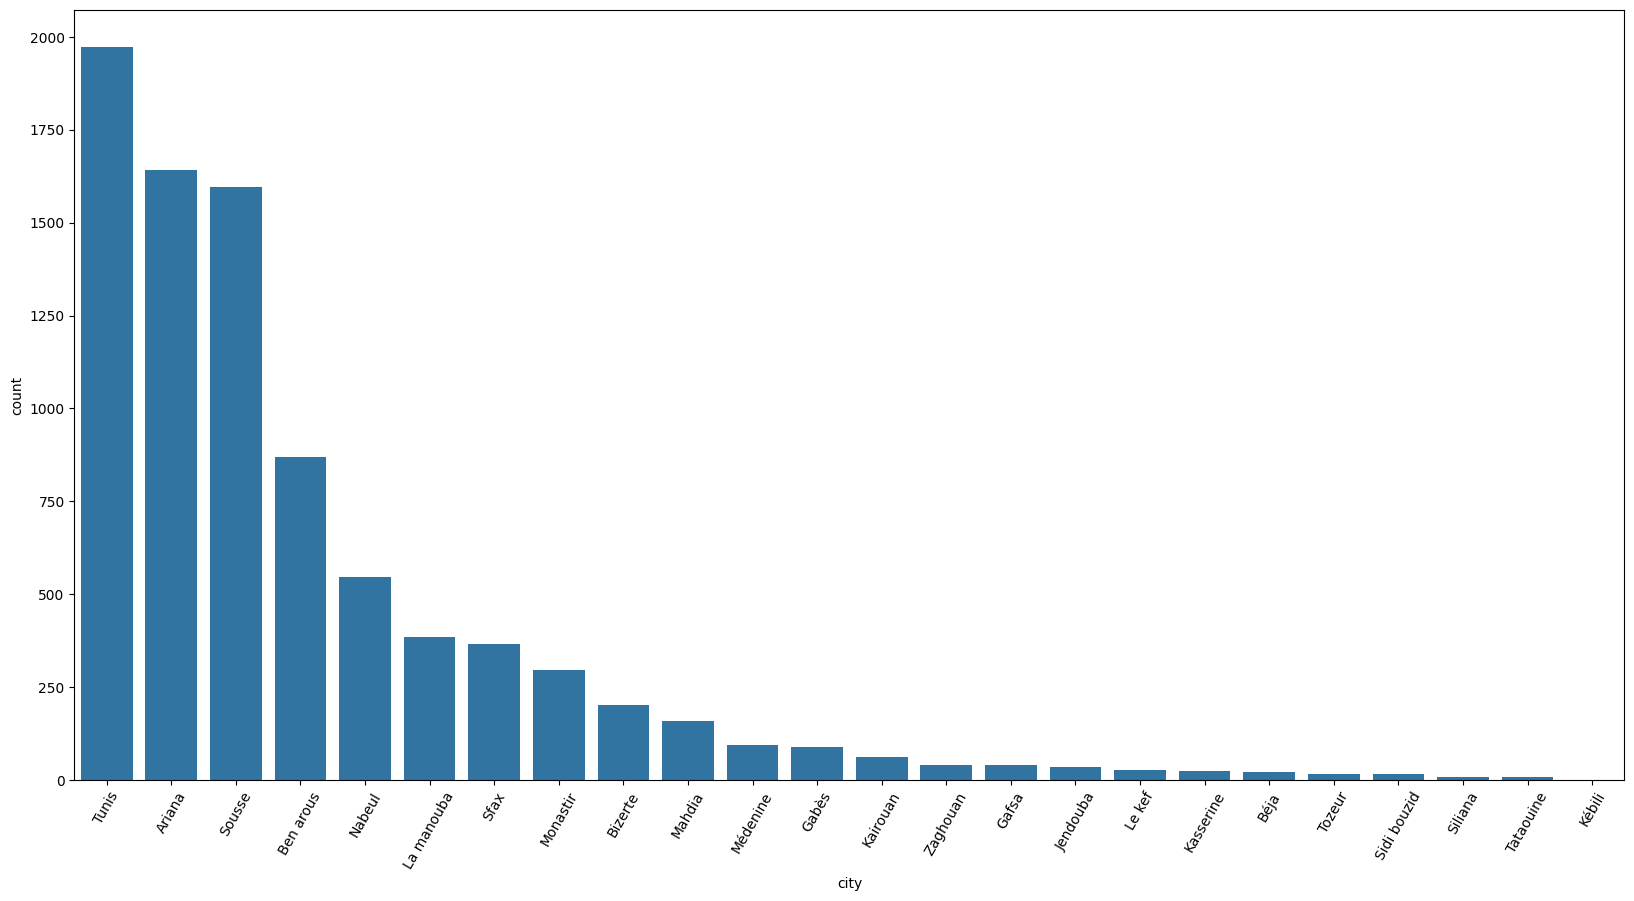

In [306]:
fig, ax = plt.subplots(figsize=(20, 10)) 

sns.countplot(df, x="city",ax=ax,order=df.city.value_counts().index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


# Size vs. Price of real estate posts visualized
We can spot a few outliers too

**Why use the logarithm of price ?**

It helps to visualize overall trends and relationships more clearly, especially when comparing prices across different ranges or property types.



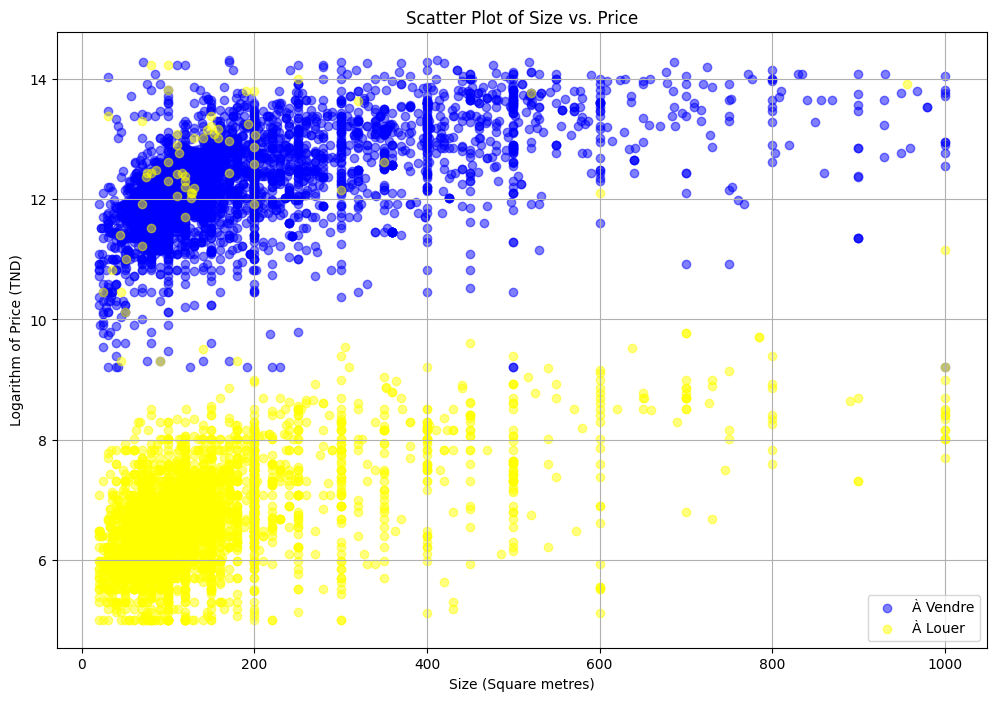

In [307]:
# Creating a scatter plot
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

plt.scatter(
    df_app["size"][df_app.type == "À Vendre"],
    [np.log(price) for price in df_app["price"][df_app.type == "À Vendre"]],
    alpha=0.5,
    color="blue",
    label="À Vendre",
)
plt.scatter(
    df_app["size"][df_app.type == "À Louer"],
    [np.log(price) for price in df_app["price"][df_app.type == "À Louer"]],
    alpha=0.5,
    color="yellow",
    label="À Louer",
)
# Adding labels and title
plt.xlabel("Size (Square metres)")
plt.ylabel("Logarithm of Price (TND)") # Log was used to help focus on changes
plt.title("Scatter Plot of Size vs. Price")
plt.legend()

plt.grid(True)  # Adding grid lines
plt.show()

In [308]:
# Séparer X et y
X = df.drop(columns=['price'])
y = df['price']

# Colonnes à encoder et à normaliser
categorical_cols = ['category', 'type', 'city', 'region']
numeric_cols = ['room_count', 'bathroom_count', 'size']



--- Évaluation du modèle ---
RMSE : 125,566.75 TND
R²   : 0.723


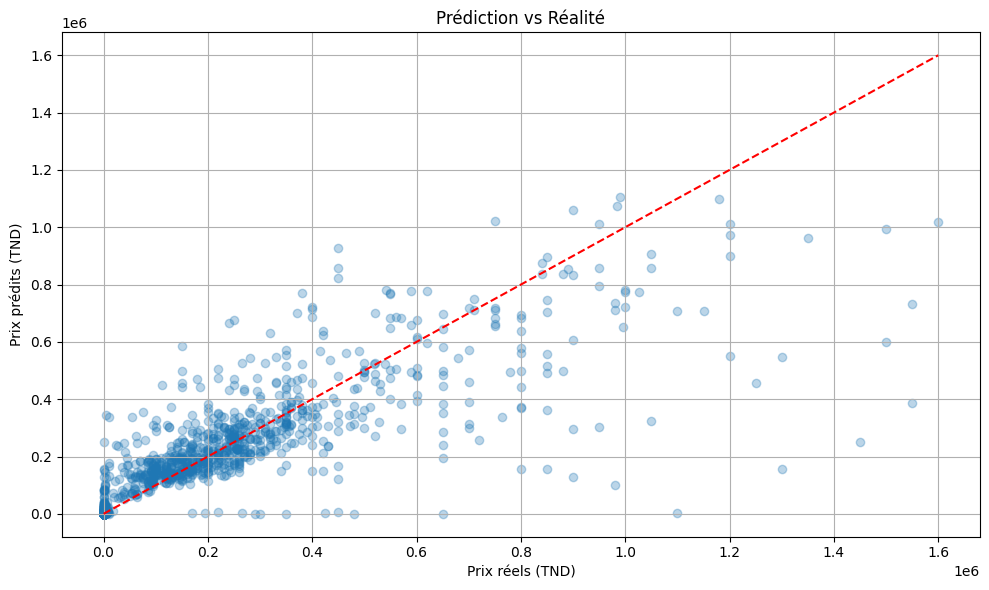

In [309]:
# Préprocesseur : pipeline de nettoyage
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]), numeric_cols),
    
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Pipeline complet
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entraînement du modèle
model_pipeline.fit(X_train, y_train)

# Prédictions
y_pred = model_pipeline.predict(X_test)

# Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Évaluation du modèle ---")
print(f"RMSE : {rmse:,.2f} TND")
print(f"R²   : {r2:.3f}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prix réels (TND)")
plt.ylabel("Prix prédits (TND)")
plt.title("Prédiction vs Réalité")
plt.grid(True)
plt.tight_layout()
plt.show()

In [310]:
# Sauvegarder le modèle dans un fichier
joblib.dump(model_pipeline, 'property_price_model.pkl')
print("Modèle sauvegardé dans 'property_price_model.pkl'")

Modèle sauvegardé dans 'property_price_model.pkl'
